### 整理好数据

In [1]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from MyDeepAR import *
data = pd.read_excel('data/副本泗洪各行业分时电量.xlsx')

In [4]:
cats = ['乡村居民', 
'交通运输、仓储和邮政业', 
'住宿和餐饮业', 
'信息传输、软件和信息技术服务业',
'公共服务及管理组织',
'农、林、牧、渔业',
'城镇居民',
'工业',
'建筑业',
'房地产业',
'批发和零售业',
'租赁和商务服务业',
'金融业']
cats_len = len(cats)
# 分别获得各个行业数据
index = data.columns[2:]
data_cats = [ data[data['行业大类一级分类']  == cat].reset_index() for cat in cats]

# 对各个行业数据依次处理
for data_cat in data_cats:
    # 获得第i时刻的数据
    for idx in index:
        ### 提取平均值并替换掉str和异常值
        # 提取useful_data
        useful_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                continue
            if float(i):
                useful_data.append(i)
        
        # 异常值识别并求取mean
        Q1 = np.quantile(useful_data, 0.25)
        Q3 = np.quantile(useful_data, 0.75)
        IQR = Q3 - Q1
        k = 0.5
        point_max = Q3 + k*IQR
        point_min = max(Q1 - k*IQR, 0)
        useful_data  = np.array(useful_data)
        mean = useful_data[(useful_data<point_max) & (useful_data>point_min)].mean()    
        # 替换掉data_cat 中 idx处的值
        replace_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                replace_data.append(mean)
            elif (float(i)>point_min) & (float(i)<point_max):
                replace_data.append(i)
            else:
                replace_data.append(mean)

        data_cat[idx] = replace_data
    
print(np.array(data_cats[1].iloc[:,3:-1]).reshape(-1).shape)

# 构造时间序列数据
load_all = np.array(data_cats[0].iloc[:,3:-1]).reshape(-1)
for i in range(1, len(cats)):
    load_all += np.array(data_cats[i].iloc[:,3:-1]).reshape(-1)
time_index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='h')

load_data = pd.DataFrame({
    'time':time_index,
    'load':load_all
})
load_data['year'] = load_data['time'].dt.year
load_data['week'] = load_data['time'].dt.weekday
load_data['month'] = load_data['time'].dt.month
load_data['hour'] = load_data['time'].dt.hour
load_data['Time_index'] = load_data['time'].dt.day*24 + load_data['time'].dt.hour
load_data.index = time_index 

# 添加气象数据在load_data中
load_data = load_data.loc['2022-05-24 00:00:00':'2023-03-30 23:00:00']
weather_data = pd.read_csv('data/泗洪气象数据.csv')
print(load_data.shape, weather_data.shape)
'''
temperature_2m  温度
total_precipitation_hourly  降水
surface_pressure  大气压力
'''
load_data['temp'] = np.array(weather_data['temperature_2m'])
load_data['precipitation'] = np.array(weather_data['total_precipitation_hourly'])
load_data['pressure'] = np.array(weather_data['surface_pressure'])
load_data['load'] = load_data['load']/1000  # 单位为MW
load_data = load_data.loc['2022-06-1 00:00:00':'2023-03-30 23:00:00']
load_data.head()

(8520,)
(7464, 7) (7464, 10)


,time,load,year,week,month,hour,Time_index,temp,precipitation,pressure
2022-06-01 00:00:00,2022-06-01 00:00:00,711.737010,2022,2,6,0,24,298.594940,0.0,100238.8086
2022-06-01 01:00:00,2022-06-01 01:00:00,705.201030,2022,2,6,1,25,300.483963,0.0,100240.5859
2022-06-01 02:00:00,2022-06-01 02:00:00,700.443880,2022,2,6,2,26,302.174927,0.0,100230.9258
2022-06-01 03:00:00,2022-06-01 03:00:00,699.116712,2022,2,6,3,27,303.698746,0.0,100195.2188
2022-06-01 04:00:00,2022-06-01 04:00:00,695.394030,2022,2,6,4,28,304.892944,0.0,100156.6328


In [12]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
data = load_data.loc['2022-06-1 00:00:00':]
print(f"数据集大小： {data.shape}")
data = data.astype(dict(hour=str, week=str, month=str))
time_varying_known_categoricals = ['hour', 'week', 'month']
time_varying_known_reals = ['temp', 'precipitation', 'pressure']
encoder_length = 72
decoder_length = 24
train_dataset = TimeSeriesDataSet(
    data=data[lambda x: x.Time_index < 520],
    time_idx="Time_index",
    target="load",
    group_ids=["month"],
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["load"],
    max_encoder_length=encoder_length,
    max_prediction_length=decoder_length,
    allow_missing_timesteps=True,
    target_normalizer=EncoderNormalizer(transformation='relu', method='standard')
)
val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data[lambda x: x.Time_index < 620], min_prediction_idx=520)
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data, min_prediction_idx=620)

# seed=20
# setup_seed(seed)

batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

test_dl = test_dataset.to_dataloader(train=False,
                                     num_workers=0,
                                     batch_sampler=BatchSampler(SequentialSampler(test_dataset),
                                                                batch_size=batch_size,
                                                                drop_last=False)
                                     )
### 定义模型
class MyDeepARN(MyDeepAR):
    def __init__(self, **kwgs):
        super().__init__(**kwgs)
        self.min_loss = 10e6
        self.early_stop_sign = 0
        
    def construct_input_vector(self, x_cat: torch.Tensor, x_cont: torch.Tensor, one_off_target: torch.Tensor = None):
        # embedding x_cat
        embeddings = {name: self.embeddings[name](x_cat[..., i]) for i, name in enumerate(self.categoricals)}
        flat_embeddings = torch.cat([embeddings[name] for name in self.categoricals], dim=-1)

        # concat with x_cont
        input_vector = torch.cat([x_cont, flat_embeddings], dim=-1)

        # shift target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        if one_off_target is not None:  # set first target input (which is rolled over)
            input_vector[:, 0, self.target_positions] = one_off_target
        else:
            input_vector = input_vector[:, 1:]
        # shift target
        return input_vector


    def decode(self,
               input_vector: torch.Tensor,
               target_scale: torch.Tensor,
               hidden_state,
               n_samples: int = None,) -> torch.Tensor:
        if n_samples is None:
            # run in train and validation
            output, _ = self.rnn(input_vector, hidden_state)  # LSTM decoder process
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=target_scale,
                                                  encoder=self.output_transformer)
        else:
            # run in test and validation
            # for every batch，sample n_samples, get n_samples trace
            target_pos = self.target_positions
            # repeat for n_samples
            input_vector = input_vector.repeat_interleave(n_samples, dim=0)  # [n_samples*batch, t, f]
            hidden_state = self.LSTMrepeat_interleave(hidden_state, n_samples)
            target_scale = target_scale.repeat_interleave(n_samples, 0)  # [6400,2]

            # define function to run at every decoding step
            def decode_one(idx, lagged_targets, hidden_state_one):
                x = input_vector[:, [idx]]  # 获得当前步的inputs
                x[:, 0, target_pos] = lagged_targets[-1]  # 使用预测norm的结果替换
                decoder_output, hidden_state_one = self.rnn(x, hidden_state_one)  # LSTM
                prediction = self.distribution_projector(decoder_output)  # gaussian 分布，还要log(1+exp(\sigma))
                prediction = prediction[:, 0]  # select first time step
                return prediction, hidden_state_one

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],  #
                first_hidden_state=hidden_state,
                target_scale=target_scale,
                n_decoder_steps=input_vector.size(1),  # time step
                n_samples=n_samples,
            )
            # reshape predictions for n_samples:
            # from n_samples * batch_size x time steps to batch_size x time steps x n_samples
            output = output.reshape(-1, n_samples, input_vector.size(1)).permute(0, 2, 1)
        return output
    
    
    def training_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],   # [64,24,18]
                                                   x["decoder_cont"],
                                                   one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 2]
                    hidden_state=hidden_state,
                    n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

        
    def mask_p(self, epoch):
        p = min(1, 0+epoch*1/7/38)
        return p

    def ss_training_step(self, batch, epoch, batch_idx, device):
        # encode
        if batch_idx%10 ==0 :
            print('pk:',self.mask_p((epoch-1)*38+batch_idx))
        self.train()
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                   x["decoder_cont"].clone(),
                                                   one_off_target)
        # 迭代每个时间步，并用预测值替换掉x中的values
        y_hat = input_vector[:, 0, self.target_positions].to(device)  # 初始化y_hat [64,1]
        out_dist = []
        for t in range(input_vector.shape[1]):
            input_vector_t = input_vector[:, [t], :].clone().to(device)  # 64,1,18
            mask = torch.rand(input_vector.shape[0], 1).to(device) < self.mask_p((epoch-1)*38+batch_idx)  # 设置选择概率，采用mask
            input_vector_t[..., 0, self.target_positions][mask] = y_hat[mask]

            # 预测
            output, hidden_state = self.rnn(input_vector_t, hidden_state)
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            # 保存每一步得到的分布，用于计算loss  (64,1,4)
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=x['target_scale'].to(device), # [64, 2]
                                                  encoder=self.output_transformer)
            # 预测得到分布 采样获得100个值  output
            dist = self.loss.map_x_to_distribution(output)
            samples = dist.sample((100, ))  # (100, 64, 1)
            samples = samples.permute(1, 0, 2).mean(1)   # (64, 1)
            # [batch*n_samples, 1， 1] 为后面scale
            # normalize prediction prediction   # (64, 1)
            y_hat = self.output_transformer.transform(samples,
                                                      target_scale=x['target_scale'].to(device))   # EncoderNormal
            y_hat.detach_()
            out_dist.append(output.squeeze())

        out_dist = torch.stack(out_dist, dim=1)
        # 计算loss
        # loss
        y_true, _ = y  # [64, 24]
        # distribution = self.map_x_to_distribution(y_pred)
        # loss = -distribution.log_prob(y_actual)
        loss = self.loss.loss(out_dist, y_true.to(self.device)).sum()
        return loss, y_true.numel(), self.mask_p(epoch) 
            
            
            
            
            
    def re_training_step(self, batch, device):
        x, y = batch
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        # 预测结果
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        with torch.no_grad():
            self.eval()
            # encode
            input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
            _, hidden_state = self.rnn(input_vector.to(device))
            # decode
            input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                       x["decoder_cont"].clone(),
                                                       one_off_target)
            y_hat = self.decode(input_vector=input_vector.to(self.device),
                        target_scale=x['target_scale'].to(self.device),  # [64, 24, 4]
                        hidden_state=hidden_state,
                        n_samples=None)
            
            # 替换掉真实值
            # y_hat_scale = (y_hat.mean(-1) - x['target_scale'][..., [0]]) / x['target_scale'][..., [1]]
            y_hat_scale = y_hat[..., 2]
            x_decoder_cont = x['decoder_cont'].clone()
            x_decoder_cont[...,self.target_positions.item()] = y_hat_scale

        # 再训练
        self.train()
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        # _, hidden_state = self.rnn(input_vector.to(device))      
        
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                           x_decoder_cont,
                                           one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 24, 4]
                    hidden_state=hidden_state,
                    n_samples=None)
            
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()


    def validation_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # deocode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],
                                                   x["decoder_cont"],
                                                   one_off_target)

        y_hat = self.decode(input_vector=input_vector.to(device),   # [64, 24, 4]
                            target_scale=x['target_scale'].to(device),
                            hidden_state=hidden_state,
                            n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

    def prediction(self, test_dl, n_samples=100):
        out = []
        x_list = []
        y_list = []
        y_pred_list = []
        decoder_y = []
        encoder_y = []
        decoder_cat = []
        decoder_time_index = []
        
        self.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dl):
                # encode
                x, y = batch
                input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
                _, hidden_state = self.rnn(input_vector.to(device))
            
                one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
                input_vector = self.construct_input_vector(x["decoder_cat"].clone(),
                                                           x["decoder_cont"].clone(),
                                                           one_off_target)

                y_hat = self.decode(input_vector=input_vector,  # [64, 24, 100]
                                    target_scale=x['target_scale'].clone(),
                                    hidden_state=hidden_state,
                                    n_samples=n_samples)
                
                # y_hat_orspace = (y_hat[..., 2] * y_hat[..., 1] + y_hat[..., 0] - y[0]).abs()
                
                out.append(y_hat)  # 记录预测结果
                decoder_y.append(y[0])  # 记录真实的y
                encoder_y.append(x['encoder_target'])  # 记录encoder部分的值
#                 x_list.append(x)  # 保存x
#                 y_list.append(y)  # 保存y
                decoder_cat.append(x['decoder_cat'])
                decoder_time_index.append(x['decoder_time_idx'])

               
                
            out = torch.cat(out, dim=0)
            decoder_y = torch.cat(decoder_y, dim=0)
            encoder_y = torch.cat(encoder_y, dim=0)
            decoder_cat = torch.cat(decoder_cat, dim=0)
            decoder_time_index = torch.cat(decoder_time_index, dim=0)
        return out, decoder_y, encoder_y, (decoder_cat,decoder_time_index) # , x_list, y_list

# 评价测试集
def val_epoch_loss(data_iter, net, device=None):
    if device is None:
        device = list(net.parameters())[0].device
        
    loss_sum, n = 0.0, 0
    with torch.no_grad():
        for batch in data_iter:
            net.eval()
            l, ynumel = net.validation_step(batch, device)
            loss_sum += l.cpu().item()
            n += ynumel
            
    return loss_sum / n



def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
    
    
def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
 #       torch.save(net.state_dict(), "model/DeepAR.pth")
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False

    
def train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    
    for epoch in range(1, epochs+1):
        # setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        for batch in train_iter:
        
            net.train()
            l, ynumel = net.training_step(batch, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        
        print('epoch %d, train loss %.4f, test loss %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, time.time() - start))

        # 保存模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_val_loss.pt")


import os
batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

数据集大小： (7272, 10)


In [13]:
device = torch.device('cpu')
print('training on', device)

# 保存模型的embeddings，接下来所有模型使用相同的embedding
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
embeddings = net.embeddings
torch.save(embeddings,"model/embeddings.pth" )
embeddings = torch.load("model/embeddings.pth")
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 50
train_net(net, train_dl, val_dl, optimizer, device, epochs)

training on cpu
epoch 1, train loss 6.0295, test loss 5.598, time 8.36 sec
call:5.597766910899769
epoch 2, train loss 5.3886, test loss 5.232, time 6.95 sec
call:5.231662026112214
epoch 3, train loss 5.1225, test loss 5.169, time 6.81 sec
call:5.169001896350415
epoch 4, train loss 5.0264, test loss 5.160, time 6.74 sec
call:5.15967659723191
epoch 5, train loss 4.9495, test loss 5.185, time 6.84 sec
epoch 6, train loss 4.8783, test loss 5.332, time 6.70 sec
epoch 7, train loss 4.8163, test loss 5.393, time 6.74 sec
epoch 8, train loss 4.7599, test loss 5.632, time 6.61 sec
epoch 9, train loss 4.7078, test loss 5.698, time 6.72 sec


In [14]:
def get_quantile_loss(r, net, out, y_true):
    net.loss.quantiles = [r]
    y_quantiles = net.to_quantiles(out, use_metric=False)
    y_quantiles.squeeze_()
    def quantile_loss(y_true, y_hat, r):
        mae = (y_true-y_hat).abs()
        loss = (2*(1-r)*mae[y_hat>y_true]).sum() + (2*(r)*mae[y_hat<=y_true]).sum()
        loss = loss/y_true.numel()
        # 归一化
        # loss = loss/y_true.mean()
        return loss
    return torch.tensor([quantile_loss(y_true[:, t], y_quantiles[:, t], 0.9) for t in range(0, 24)])


device = torch.device('cpu')
embeddings = torch.load("model/embeddings.pth")

r = 0.9
seed = 12
### 加载模型
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')
torch.save(mae, f"loss/mae_deepar_seed{seed}.pt")
# 分位数损失
qloss = get_quantile_loss(r, net, out, y_true)
print(f'net1 Qloss:{[qloss[i].item() for i in index]}, mean:{qloss.mean().item()}')
torch.save(qloss, f"loss/qloss_deepar_seed{seed}.pt")

net1 MAE:[31.645559310913086, 40.76866149902344, 44.170127868652344, 44.377586364746094, 44.673866271972656], mean:42.1215705871582
net1 MAPE:[3.981501579284668, 5.085278034210205, 5.459259033203125, 5.509280204772949, 5.642125129699707], mean:5.250185012817383
net1 Qloss:[15.052358627319336, 19.45757293701172, 20.860376358032227, 20.60600471496582, 20.1910343170166], mean:19.7209529876709


In [34]:
# 画图，多步预测结果展示和loss收敛过程
device = torch.device('cpu')
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
print(out.shape)
encoder_target = encoder_y
decoder_target = y_true
y_hats = net.to_prediction(out, use_metric=False)  # mean

net.loss.quantiles = [0.005,0.05, 0.25, 0.75, 0.95, 0.995]
y_quantiles = net.to_quantiles(out, use_metric=False)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdate
import matplotlib.ticker as ticker

def get_time_range(idx):
    hour_label = train_dataset.categorical_encoders['hour']
    week_label = train_dataset.categorical_encoders['week']
    month_label = train_dataset.categorical_encoders['month']

    hours = hour_label.inverse_transform(decoder_cat[idx, :, 0]).astype(int)
    weeks = week_label.inverse_transform(decoder_cat[idx, :, 1]).astype(int)
    months = month_label.inverse_transform(decoder_cat[idx, :, 2]).astype(int)
    day = int(decoder_time_index[idx,:][0]/24)+1
    start_point = pd.Timestamp(year=2022, month=months[0], day=day,  hour=hours[0])
    time_pred =  pd.to_datetime(np.arange(0,24), unit='h', origin=start_point)
    time_start = time_pred.shift(-72, freq='h')
    for t in [-48,-24, 0]:
        time_start = time_start.append(time_pred.shift(t, freq='h'))
    return time_start

torch.Size([1082, 24, 100])


In [46]:
.shape

torch.Size([100, 24])

### 绘制100条轨迹，

预测开始时间: 2022-07-29 00:00:00


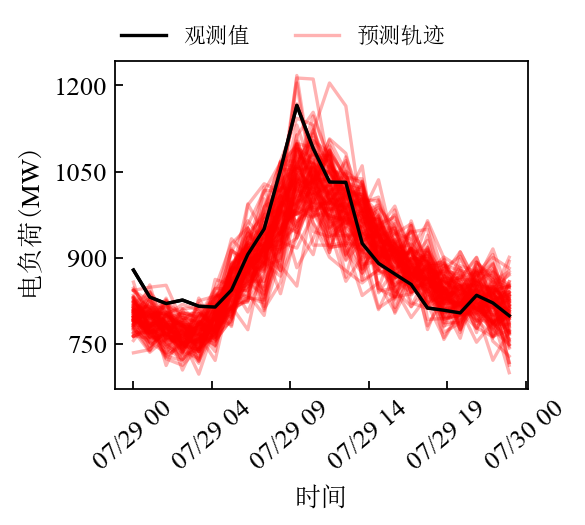

In [64]:
idx = 15 +24*32# 画图的id  720 150 60
time_range = get_time_range(idx)
print('预测开始时间:',time_range[-24])

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)

pred_len = 24
x_pred = time_range[-pred_len:]
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列


y_pred = out[idx,...].permute(1,0)
ax.plot(x_pred, y[-pred_len:], color='k', linestyle='-', linewidth=1.5)  # 真实值
for i in range(len(y_pred)):
    ax.plot(x_pred, y_pred[i,:], color='r', linestyle='-', linewidth=1.5, alpha=0.3)  
ax.plot(x_pred, y[-pred_len:], color='k', linestyle='-', linewidth=1.5)  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
    
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
plt.legend(['观测值', '预测轨迹'],frameon=False, fontsize=10, bbox_to_anchor=(0.85, 1.17), prop=legend_font, ncol=2)

### 超峰预警

预测开始时间: 2022-07-31 00:00:00
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  8., 39., 85., 92., 89., 82.,
        64., 20.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])


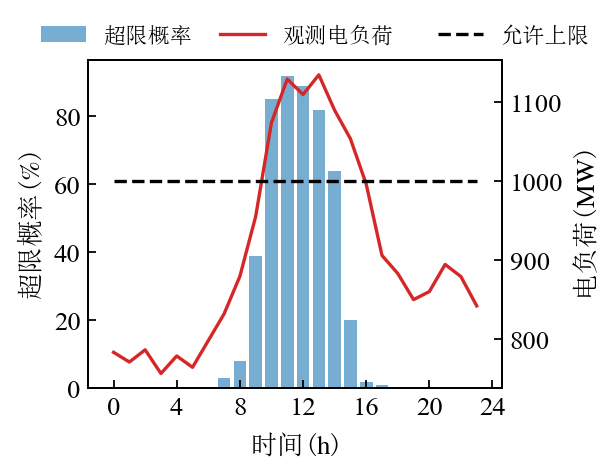

In [337]:
idx = 15 +24*34# 画图的id  720 150 60
time_range = get_time_range(idx)
print('预测开始时间:',time_range[-24])
y_pred = out[idx,...].permute(1,0)
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
y_need = y[-pred_len:]-1000
y_need[y_need<0] = 0

prob = (y_pred > 1000).sum(0)/100*100
print(prob)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns# create figure

config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)

ax.bar(np.arange(0,24), prob, color=color_list[1], alpha=0.6)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间(h)', fontfamily="SimSun")

legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('超限概率($\%$)', fontfamily="SimSun")
ax.set_xlabel('时间($\mathrm{h}$)', fontfamily="SimSun")
ax.legend(['超限概率'],frameon=False, fontsize=10, bbox_to_anchor=(0.3, 1.17), prop=legend_font, ncol=2)


ax2 = ax.twinx()
ax2.plot(np.arange(0,24), y[-pred_len:], color=color_list[4])

ax2.plot(np.arange(0,24), np.ones(24)*1000,  color='k', linestyle='--')
ax2.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax2.legend(['观测电负荷','允许上限'],frameon=False, fontsize=10, bbox_to_anchor=(1.26, 1.17), prop=legend_font, ncol=2)

### 可调负荷量准备好
工业\
公共服务及管理组织\
信息传输、软件和信息技术服务业\
农、林、牧、渔业\

In [76]:
#  分析时间
analysis_time = '20220731'

# 获得各行业在此时刻的可调负荷量
analysis_idxs = [7,4,3,5]
temp_time = []
load_schedule_time = []
for analysis_idx in analysis_idxs:
    print(cats[analysis_idx])
    # 构造时间序列数据
    load = np.array(data_cats[analysis_idx].iloc[:,3:-1]).reshape(-1)
    # time_index.dt
    time_index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='h')
    load_data = pd.DataFrame({
        'time':time_index,
        'load':load
    })
    load_data['year'] = load_data['time'].dt.year
    load_data['week'] = load_data['time'].dt.weekday
    load_data['month'] = load_data['time'].dt.month
    load_data['hour'] = load_data['time'].dt.hour
    load_data['Time_index'] = load_data['time'].dt.day*24 + load_data['time'].dt.hour
    load_data.index = time_index 
    load_data = load_data.loc['2022-05-24 00:00:00':'2023-03-30 23:00:00']
    weather_data = pd.read_csv('data/泗洪气象数据.csv')
    print(load_data.shape, weather_data.shape)
    # 添加气象数据在load_data中
    '''
    temperature_2m  温度
    total_precipitation_hourly  降水
    surface_pressure  大气压力
    '''
    load_data['temp'] = np.array(weather_data['temperature_2m'])
    load_data['precipitation'] = np.array(weather_data['total_precipitation_hourly'])
    load_data['pressure'] = np.array(weather_data['surface_pressure'])
    load_data['load'] = load_data['load']/1000  # 单位为MW 
    load_data = load_data.loc['2022-06-1 00:00:00':'2023-03-30 23:00:00']
    # 记录温度h
    temp_time.append(np.array(load_data.loc[analysis_time]['temp']))
    load_schedule_time.append(np.array(load_data.loc[analysis_time]['load']))

工业
(7464, 7) (7464, 10)
公共服务及管理组织
(7464, 7) (7464, 10)
信息传输、软件和信息技术服务业
(7464, 7) (7464, 10)
农、林、牧、渔业
(7464, 7) (7464, 10)


In [145]:
# 各个行业的f(T)
def fun1(T):
    return 23.8158*T+13255.70

def fun2(T):
    return 1.2460*T**2-38.4207*T+726.9453

def fun3(T):
    return -2.6754*T+456.9147

def fun4(T):
    return 0.1933*T**2+7.3403*T+310.9861


funs = [fun1, fun2 , fun3, fun4]  # 计算各行业负荷基础成分f(T)

fT = [f(t.mean()-273.15) for t,f in zip(temp_time,funs)]
# 分解fT
p1 = np.array([1.08874854, 1.05480083, 1.05125437, 1.05369358, 1.06204338,
1.07929256, 1.13118704, 1.20466008, 1.21883358, 1.31877661,
1.41806911, 1.46683925, 1.45429701, 1.41845307, 1.35944503,
1.26967271, 1.18323583, 1.10244705, 1.06040661, 1.05363499,
1.04276993, 1.05099884, 1.056546  , 1.        ])

p2 = np.array([1.11139704, 1.08756086, 1.04122313, 1.        , 1.07902633,
1.14566294, 1.29460382, 1.51252751, 1.75021139, 1.89447159,
1.86426814, 1.7876805 , 1.64866962, 1.57187121, 1.64843845,
1.72003571, 1.74932138, 1.64383402, 1.5755745 , 1.52618543,
1.46343935, 1.44479966, 1.35805979, 1.21689651])
    
p3 = np.array([1.24594493, 1.20487357, 1.19482682, 1.18533023, 1.18149766,
1.21524238, 1.24998627, 1.27950546, 1.34041042, 1.38344461,
1.40251121, 1.41938666, 1.42215995, 1.42245222, 1.42159671,
1.41880597, 1.44501164, 1.464099  , 1.45410683, 1.20231167,
1.        , 1.30509951, 1.37300185, 1.34858449])

p4 = np.array([1.13522309, 1.20574691, 1.01221711, 1.02186549, 1.03753923,
1.08747995, 1.17801082, 1.18828242, 1.18622122, 1.20528673,
1.23165235, 1.22551359, 1.18668487, 1.15879142, 1.17584036,
1.19468485, 1.20833847, 1.1958075 , 1.13551153, 1.11403768,
1.        , 1.00868807, 1.02095516, 1.01883073])

ps = [p1, p2, p3, p4]
fT[0]/ps[0].sum()*ps[0]

array([537.51944176, 520.75932364, 519.00842237, 520.21266996,
       524.3349991 , 532.85098719, 558.47149633, 594.74542552,
       601.74293829, 651.08520578, 700.10630405, 724.18431423,
       717.99216095, 700.29586661, 671.16336489, 626.84241698,
       584.16818893, 544.28245009, 523.5269193 , 520.18374384,
       514.81962093, 518.88226621, 521.62092094, 493.70393806])

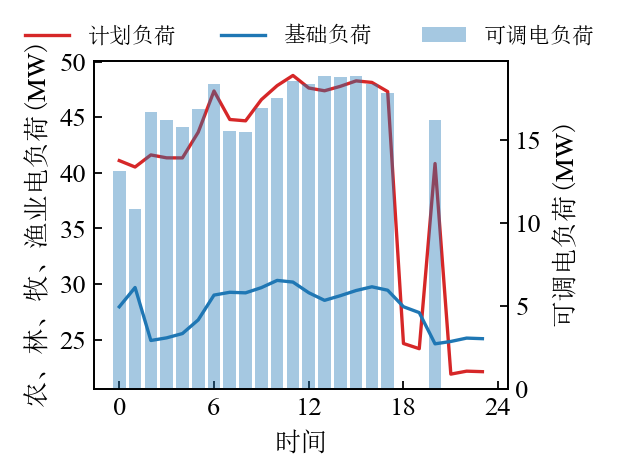

In [148]:
i = 3
loadlow = fT[i]/ps[i].sum()*ps[i]
loads = load_schedule_time[i]
loadadj = loads - loadlow
loadadj[loadadj<=0] = 0

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns# create figure

config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
ax.plot(np.arange(0,24), loads, color=color_list[4])
ax.plot(np.arange(0,24), loadlow, color=color_list[0])

ax2 = ax.twinx()
ax2.bar(np.arange(0,24), loadadj, alpha=0.4)

ax.xaxis.set_major_locator(ticker.MultipleLocator(6))

ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间(h)', fontfamily="SimSun")

legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel(cats[analysis_idxs[i]][0:8]+'电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
ax.legend(['计划负荷', '基础负荷'],frameon=False, fontsize=10, bbox_to_anchor=(0.72, 1.17), prop=legend_font, ncol=2)

ax2.set_ylabel('可调电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax2.legend(['可调电负荷'],frameon=False, fontsize=10, bbox_to_anchor=(1.26, 1.17), prop=legend_font, ncol=2)

### 预测后随机优化调度

In [346]:
# 各行业可调负荷上限
Xup = []
for i in range(4):
    loadlow = fT[i]/ps[i].sum()*ps[i]
    loads = load_schedule_time[i]
    loadadj = loads - loadlow
    loadadj[loadadj<=0] = 0
    Xup.append(loadadj)

# 价格成本
C = [1.3, 1.5, 1.57, 1.8, 5]

# 预测结果
fa = y_pred - 1000
fa[fa < 0] = 0

from scipy.optimize import minimize, Bounds

def min_function(x):
    global C, fa
    def fun_C(l):
        l[l <= 0]=0
        l = l*C[4]
        return l
    
    target = 0
    for i in range(4):
        target += (x[24*(i):24*(i+1)]*C[i]).sum()
    target += fun_C(fa - x.reshape(4, -1).T.sum(1)).sum()/100
    return target

bnds = Bounds(lb=np.zeros(24*4), ub=np.array(Xup).reshape(-1))
res = minimize(fun=min_function, x0=np.zeros(24*4), bounds=bnds)
result = res.x.reshape(4, -1)

In [386]:
print('2022-07-31日工业可调负荷量：', Xup[0])
print('2022-07-31日公共服务及管理组织可调负荷量：', Xup[1])
print('2022-07-31日信息传输可调负荷量：', Xup[2])
print('2022-07-31日农、林、牧、渔业可调负荷量：', Xup[3])

2022-07-31日工业可调负荷量： [76.12267824 87.28142636 80.32390763 70.82428004 43.9771309  26.95592281
  6.72494367  0.         11.98799171 11.92621422 26.83055595 49.51950577
 48.08294905 56.96147339 76.44761511 89.75033302 67.43544107 20.31285991
  0.          0.          8.57768907 12.21219379  7.09193906 24.74579194]
2022-07-31日公共服务及管理组织可调负荷量： [14.46978813 12.91716009 14.23044027 14.42297766 11.47677699 10.9571167
 10.78348941 12.6657384  15.18343525 17.51550534 19.06870896 20.24432313
 18.56443241 18.38438366 16.87959409 18.62380254 19.16887232 20.32797866
 15.06716508 14.7757916  16.09037679 14.37542233 15.93965642 15.51963535]
2022-07-31日信息传输可调负荷量： [1.50386158 1.87310883 1.45511874 1.19965367 1.37086413 1.15475314
 1.05356575 1.69962863 1.97149542 2.32256491 2.52697692 2.49032405
 2.80744711 3.19133169 3.30995031 3.62620833 3.85927301 3.6026339
 3.00661359 3.8596387  2.18726973 1.52804173 2.55559513 2.43023827]
2022-07-31日农、林、牧、渔业可调负荷量： [13.1473519  10.83383342 16.685555   16.1859475  15.

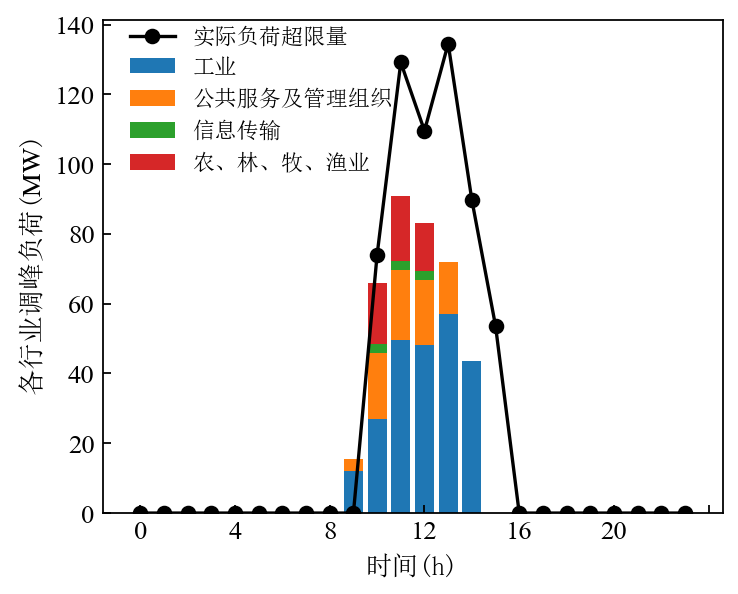

In [378]:
### 绘制结果
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5, 4))
ax = fig.add_subplot(111)
lables = [ '工业','公共服务及管理组织', '信息传输','农、林、牧、渔业']
x = np.arange(0,24).astype('str')
for i in np.arange(0, 4):
    ax.bar(x, result[i,:],  bottom=result[0:i,:].sum(0), color=color_list[i+1], alpha=1)
    
legend_font = {"family":"SimSun", "size":10}
#ax.legend([ '工业','公共服务及管理组织', '信息传输','农、林、牧、渔业','实际负荷超限量'],frameon=False, fontsize=10, prop=legend_font) # ncol=2   bbox_to_anchor=(0.3, 1.17)
ax.plot(np.arange(0,24), y_need,  color='k', linestyle='-', marker='o', label='实际负荷超限量')
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_ylabel('各行业调峰负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间(h)', fontfamily="SimSun")

ax.legend([ '实际负荷超限量', '工业','公共服务及管理组织', '信息传输','农、林、牧、渔业'],frameon=False, fontsize=10, prop=legend_font, bbox_to_anchor=(0.5, 0.65)) # ncol=2   bbox_to_anchor=(0.3, 1.17)

In [389]:
print('2022-07-31日工业可调负荷参与调峰量：\n', result[0, :])
print('2022-07-31日公共服务及管理组织可调负荷参与调峰量：\n', result[1, :])
print('2022-07-31日信息传输可调负荷参与调峰量：\n', result[2, :])
print('2022-07-31日农、林、牧、渔业可调负荷参与调峰量：\n', result[3, :])

2022-07-31日工业可调负荷参与调峰量：
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         11.92621422 26.83055595 49.51950577
 48.08294905 56.96147339 43.59685114  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
2022-07-31日公共服务及管理组织可调负荷参与调峰量：
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.54545927 19.06870896 20.24432313
 18.56443241 15.0073416   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
2022-07-31日信息传输可调负荷参与调峰量：
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         2.52697692 2.49032405
 2.80744711 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
2022-07-31日农、林、牧、渔业可调负荷参与调峰量：
 [ 0.          0.          0.          0.          0.          0.
  0.         

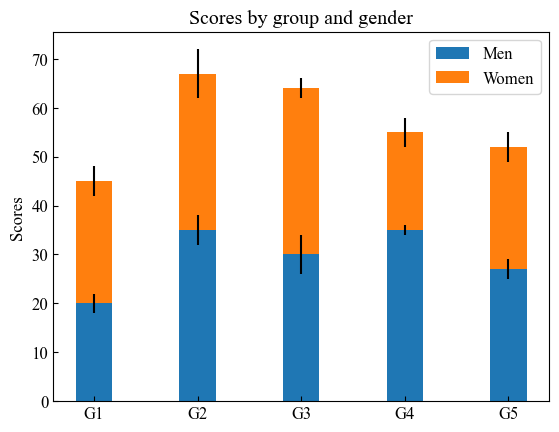

In [324]:
import numpy as np
import matplotlib.pyplot as plt


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
# label = 'Men'显示在图例中，labels为x轴的。
ax.bar(labels, men_means, width, yerr=men_std, label='Men')
ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
       label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()
plt.show()